<img src="img.jpg">

# Workout Classification
Now it's possible to collect a large amount of data about personal movement using activity monitoring devices such as a [Fitbit](http://www.fitbit.com), [NikeFuelband](http://www.nike.com/us/en_us/c/nikeplus-fuelband), or [Jawbone Up](https://jawbone.com/up). These type of devices are part of the "quantified self" movement, a group of enthusiasts who take measurements about themselves regularly to improve their health or to find patterns in their behavior. Unfurtunatelly, these data remain under-utilized both because the raw data are hard to obtain and there is a lack of statistical methods and software for processing and interpreting the data.

Usually, people quantify the amount of exercise they do but don't the quality of it. The objective of this project is to use the data from accelerometers on the belt, forearm, arm, and dumbbell to classify when an exercise is done correctly or not.

This project is structured as follows:
1. [Understanding the Data](#Understanding_the_Data)
    1. [Descriptive and Exploratory Analysis](#Descriptive_and_Exploratory_Analysis)
        1. [Anomaly Detection](#Anomaly_Detection)
    2. [Training and Validation Dataset](#Training_and_Validation_Dataset)
2. [Feature Selection/Importance](#Feature_Selection_Importance)
3. [Classification Model](#Classification_Model)
4. [Conclusions and Remarks](#Conclusions_and_Remarks)

## Understanding the Data
<a id='Understanding_the_Data'></a>

This project is possible thanks to the data obtained from [here](http://groupware.les.inf.puc-rio.br/har#weight_lifting_exercises). Also, the owners of this dataset have an [available publication](http://groupware.les.inf.puc-rio.br/public/papers/2013.Velloso.QAR-WLE.pdf). 

The experimental design was conducted in accordance with the next points:
1. The exercises were performed by 6 young (20-28 years old) healthy participants.
2. Each participant did 10 repetitions of "Unilateral Dumbbell Biceps Curl" in 5 different fashions:
    1. _Class A_: Exactly as the specifications (high quality performance)
    2. _Class B_: Throwing the elbows to the front (mistake).
    3. _Class C_: Lifting the dumbbell only halfway (mistake).
    4. _Class D_: Lowering the dumbbell only halfway (mistake).
    5. _Class E_: Throwing the hips to the front (mistake).
3. Four sensors were used to collect the data (in the glove, armband, lumbar belt and dumbbell), as it is represented in the below figure (this figure was inspired by the schema proposed by the author [here](http://groupware.les.inf.puc-rio.br/public/papers/2013.Velloso.QAR-WLE.pdf)).
4. Each sensor acts as a center of a euclidean coordinates system, so, for each sensor was possible to record it's [intrinsic rotations](https://en.wikipedia.org/wiki/Euler_angles) (yaw, pitch, and roll), in addition to the [gyroscope](https://en.wikipedia.org/wiki/Gyroscope), [accelerometer](https://en.wikipedia.org/wiki/Accelerometer), and [magnetometer](https://en.wikipedia.org/wiki/Magnetometer) values for each axis of the coordinate system.
    
<img src="workout_body.png">

More details about this data can be consulted [here](http://groupware.les.inf.puc-rio.br/har#weight_lifting_exercises).

## Descriptive and Exploratory Analysis
<a id='Descriptive_and_Exploratory_Analysis'></a>

In [73]:
# Load Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from functions import *

In [74]:
# Load Dataset
raw_data=pd.read_csv('WearableComputing_weight_lifting_exercises_biceps_curl_variations.csv',low_memory=False)
# Make a copy of the data
curl_variation=raw_data.copy()
print('The dataset is composed by {} instances and {} features.'.format(
    curl_variation.shape[0],curl_variation.shape[1]))

The dataset is composed by 39242 instances and 159 features.


In [75]:
# Get some information about the dataset
curl_variation.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39242 entries, 0 to 39241
Columns: 159 entries, user_name to classe
dtypes: float64(99), int64(23), object(37)
memory usage: 47.6+ MB


The target variable is `classe`, and as we can see below, there is a little imbalance between class A and the other classes that we need to take care of. Nevertheless, by the moment lets put the target variable out of the dataset.

In [76]:
# Count the categories frequency of the target variable
curl_variation['classe'].value_counts()

A    11159
B     7593
E     7214
C     6844
D     6432
Name: classe, dtype: int64

In [111]:
# Create the target and explanation dataset
y = curl_variation['classe']
X = curl_variation.drop(columns='classe')

Before going forward, lets split the dataset to create a test set that we only are going to use at the end of the analysis to prove the efficiency of the predictive algorithm. Because I want to keep the proportion of classes of the original dataset in the test data, I am not going to use the classical `train_test_split` method in sklearn, but the method `StratifiedShuffleSplit`.

In [112]:
# Create a test dataset
from sklearn.model_selection import StratifiedShuffleSplit
# Create an object StratifiedShuffleSplit
stratSplit = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
# Create the training and testing dataset
for train_index, test_index in stratSplit.split(X, y):
    X_train, X_test = X.loc[train_index,:], X.loc[test_index,:]
    y_train, y_test = y[train_index], y[test_index]
print('The training data is composed by {} observations and {} variables.'.format(X_train.shape[0],
                                                                                 X_train.shape[1]))
print('The test data is composed by {} observations and {} variables.'.format(X_test.shape[0],
                                                                                 X_test.shape[1]))

The training data is composed by 31393 observations and 158 variables.
The test data is composed by 7849 observations and 158 variables.


Also, I am going to split the current training dataset in `validation` and `train`. The validation dataset is going to be used for the parameter tuning.

In [113]:
from sklearn.model_selection import train_test_split
# Split the train and test dataset
X_train, X_val, y_train, y_val = train_test_split(X_train,y_train,test_size=0.2,random_state=1)

In all the following sections we are going to work only on the `X_train`, `y_train` dataset. For each modification of the training data, I am going to do the same modification in the validation data, with the difference that in the last case I am going to use the functions implemented in the file `functions.py`. This is going to work also as a proof of concept for each function that will be enrolled in the final data cleaning function.

In [114]:
# Display the head of our data frame
pd.set_option('display.max_columns',None)
X_train.head()

,user_name,raw_timestamp_part_1,raw_timestamp_part_2,cvtd_timestamp,new_window,num_window,roll_belt,pitch_belt,yaw_belt,total_accel_belt,kurtosis_roll_belt,kurtosis_picth_belt,kurtosis_yaw_belt,skewness_roll_belt,skewness_roll_belt.1,skewness_yaw_belt,max_roll_belt,max_picth_belt,max_yaw_belt,min_roll_belt,min_pitch_belt,min_yaw_belt,amplitude_roll_belt,amplitude_pitch_belt,amplitude_yaw_belt,var_total_accel_belt,avg_roll_belt,stddev_roll_belt,var_roll_belt,avg_pitch_belt,stddev_pitch_belt,var_pitch_belt,avg_yaw_belt,stddev_yaw_belt,var_yaw_belt,gyros_belt_x,gyros_belt_y,gyros_belt_z,accel_belt_x,accel_belt_y,accel_belt_z,magnet_belt_x,magnet_belt_y,magnet_belt_z,roll_arm,pitch_arm,yaw_arm,total_accel_arm,var_accel_arm,avg_roll_arm,stddev_roll_arm,var_roll_arm,avg_pitch_arm,stddev_pitch_arm,var_pitch_arm,avg_yaw_arm,stddev_yaw_arm,var_yaw_arm,gyros_arm_x,gyros_arm_y,gyros_arm_z,accel_arm_x,accel_arm_y,accel_arm_z,magnet_arm_x,magnet_arm_y,magnet_arm_z,kurtosis_roll_arm,kurtosis_picth_arm,kurtosis_yaw_arm,skewness_roll_arm,skewness_pitch_arm,skewness_yaw_arm,max_roll_arm,max_picth_arm,max_yaw_arm,min_roll_arm,min_pitch_arm,min_yaw_arm,amplitude_roll_arm,amplitude_pitch_arm,amplitude_yaw_arm,roll_dumbbell,pitch_dumbbell,yaw_dumbbell,kurtosis_roll_dumbbell,kurtosis_picth_dumbbell,kurtosis_yaw_dumbbell,skewness_roll_dumbbell,skewness_pitch_dumbbell,skewness_yaw_dumbbell,max_roll_dumbbell,max_picth_dumbbell,max_yaw_dumbbell,min_roll_dumbbell,min_pitch_dumbbell,min_yaw_dumbbell,amplitude_roll_dumbbell,amplitude_pitch_dumbbell,amplitude_yaw_dumbbell,total_accel_dumbbell,var_accel_dumbbell,avg_roll_dumbbell,stddev_roll_dumbbell,var_roll_dumbbell,avg_pitch_dumbbell,stddev_pitch_dumbbell,var_pitch_dumbbell,avg_yaw_dumbbell,stddev_yaw_dumbbell,var_yaw_dumbbell,gyros_dumbbell_x,gyros_dumbbell_y,gyros_dumbbell_z,accel_dumbbell_x,accel_dumbbell_y,accel_dumbbell_z,magnet_dumbbell_x,magnet_dumbbell_y,magnet_dumbbell_z,roll_forearm,pitch_forearm,yaw_forearm,kurtosis_roll_forearm,kurtosis_picth_forearm,kurtosis_yaw_forearm,skewness_roll_forearm,skewness_pitch_forearm,skewness_yaw_forearm,max_roll_forearm,max_picth_forearm,max_yaw_forearm,min_roll_forearm,min_pitch_forearm,min_yaw_forearm,amplitude_roll_forearm,amplitude_pitch_forearm,amplitude_yaw_forearm,total_accel_forearm,var_accel_forearm,avg_roll_forearm,stddev_roll_forearm,var_roll_forearm,avg_pitch_forearm,stddev_pitch_forearm,var_pitch_forearm,avg_yaw_forearm,stddev_yaw_forearm,var_yaw_forearm,gyros_forearm_x,gyros_forearm_y,gyros_forearm_z,accel_forearm_x,accel_forearm_y,accel_forearm_z,magnet_forearm_x,magnet_forearm_y,magnet_forearm_z
36557,eurico,1322489664,218625,28/11/2011 14:14,no,806,1.10,2.53,-89.0,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.05,0.02,-0.03,-4,-1,23,27,573,-433,143.0,-5.15,-105.0,57,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.89,-0.74,0.13,-83,-44,-547,-232,-201,-496,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.714818,38.681582,118.355989,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.42,-0.45,-0.92,22,-1,54,-345.0,230.0,387.0,-177.0,11.70,113.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.19,-1.16,0.03,-73.0,330.0,207,-790.0,1180.0,-546.0
13155,eurico,1322489703,734687,28/11/2011 14:15,no,292,-23.60,-3.00,-88.9,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.16,-0.13,-0.30,-28,-6,91,-37,657,-223,97.1,-13.80,31.2,19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.89,-1.57,0.07,-21,187,-13,647,78,267,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,52.660030,16.832614,101.245058,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.40,0.56,0.03,16,48,81,-265.0,318.0,375.0,-176.0,18.00,14.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,31,NaN,NaN,N

If you explore the above table, you can see that a lot of variables have not assigned values at least in the first 5 instances. Therefore, let's see what is the average of NaN for each feature in our dataset and erase the variables with more than 40% of missing values.
> This threshold was selected taking into account that best algorithms/methods have a breaking point of 50%, this is, it's necessary at least 50% of the data in the distribution to make relative accurate estimations (for example the median). If we are going to impute the missing values, we need enough information in the variable, otherwise, it's better to drop the variable.

In [115]:
# Compute the average of rows with missing values per variable and only keep columns with 60%+ of information
pd.set_option('display.max_rows',None)
columns_out=X_train.columns[(X_train.isna().sum()/len(X_train)>0.4).values]
print('The {}% of the variables have more than 40% of the observations as NaN.'.format(
    round(100*len(columns_out)/X_train.shape[1],2)))

The 63.29% of the variables have more than 40% of the observations as NaN.


In [116]:
# Drop the columns with more than 40% of missing data
X_train.drop(columns=columns_out,inplace=True)
print('Now our data is composed by {} observations and {} variables. This is \
a hugh reduction of dimensionaity.'.format(
    X_train.shape[0],X_train.shape[1]))
X_train.head()

Now our data is composed by 25114 observations and 58 variables. This is a hugh reduction of dimensionaity.


,user_name,raw_timestamp_part_1,raw_timestamp_part_2,cvtd_timestamp,new_window,num_window,roll_belt,pitch_belt,yaw_belt,total_accel_belt,gyros_belt_x,gyros_belt_y,gyros_belt_z,accel_belt_x,accel_belt_y,accel_belt_z,magnet_belt_x,magnet_belt_y,magnet_belt_z,roll_arm,pitch_arm,yaw_arm,total_accel_arm,gyros_arm_x,gyros_arm_y,gyros_arm_z,accel_arm_x,accel_arm_y,accel_arm_z,magnet_arm_x,magnet_arm_y,magnet_arm_z,roll_dumbbell,pitch_dumbbell,yaw_dumbbell,total_accel_dumbbell,gyros_dumbbell_x,gyros_dumbbell_y,gyros_dumbbell_z,accel_dumbbell_x,accel_dumbbell_y,accel_dumbbell_z,magnet_dumbbell_x,magnet_dumbbell_y,magnet_dumbbell_z,roll_forearm,pitch_forearm,yaw_forearm,total_accel_forearm,gyros_forearm_x,gyros_forearm_y,gyros_forearm_z,accel_forearm_x,accel_forearm_y,accel_forearm_z,magnet_forearm_x,magnet_forearm_y,magnet_forearm_z
36557,eurico,1322489664,218625,28/11/2011 14:14,no,806,1.10,2.53,-89.0,2,-0.05,0.02,-0.03,-4,-1,23,27,573,-433,143.0,-5.15,-105.0,57,1.89,-0.74,0.13,-83,-44,-547,-232,-201,-496,-1.714818,38.681582,118.355989,6,0.42,-0.45,-0.92,22,-1,54,-345.0,230.0,387.0,-177.0,11.70,113.0,40,0.19,-1.16,0.03,-73.0,330.0,207,-790.0,1180.0,-546.0
13155,eurico,1322489703,734687,28/11/2011 14:15,no,292,-23.60,-3.00,-88.9,10,-0.16,-0.13,-0.30,-28,-6,91,-37,657,-223,97.1,-13.80,31.2,19,3.89,-1.57,0.07,-21,187,-13,647,78,267,52.660030,16.832614,101.245058,10,-0.40,0.56,0.03,16,48,81,-265.0,318.0,375.0,-176.0,18.00,14.1,31,-0.34,-4.27,-0.92,74.0,262.0,133,236.0,143.0,-280.0
20336,jeremy,1322673080,842742,30/11/2011 17:11,no,443,1.00,3.35,-88.0,4,0.16,0.03,0.02,-15,7,40,44,632,-300,0.0,0.00,0.0,31,-3.24,1.64,-0.13,79,27,-291,595,-189,-342,84.399179,-37.280696,-58.928443,32,-0.05,1.65,0.18,-116,238,-177,-249.0,565.0,62.0,165.0,38.30,-149.0,22,0.06,-4.29,-1.90,-66.0,22.0,-208,-454.0,-279.0,311.0
17667,carlitos,1323084316,292315,05/12/2011 11:25,no,388,1.36,6.95,-93.6,3,0.02,0.02,-0.05,-17,4,21,0,598,-310,71.8,14.90,100.0,31,1.56,-0.56,0.34,-264,138,-54,-286,334,547,88.276474,11.058202,67.558652,3,-0.13,-0.02,0.31,3,21,17,-524.0,335.0,-10.0,136.0,7.29,95.6,38,-0.05,0.00,-0.02,127.0,270.0,-221,-207.0,705.0,407.0
10556,eurico,1322489637,174724,28/11/2011 14:13,no,237,1.40,3.53,-88.8,3,-0.02,0.00,-0.03,-9,5,26,36,574,-430,76.8,-26.30,44.1,16,3.23,-0.92,0.34,17,154,-45,583,37,387,-114.746433,-41.720984,-6.758665,3,0.16,-0.31,-0.25,-12,-27,-2,-442.0,234.0,298.0,172.0,16.20,109.0,36,-0.24,-0.24,0.33,-69.0,286.0,203,-685.0,1150.0,-528.0


In [117]:
# Check if exist other variable with NaN
var_with_nan=X_train.isna().sum()[X_train.isna().sum()!=0]
print('The remain variables with not assigned value are {} with {} missing values'.format(var_with_nan.index,
                                                                                        var_with_nan.values))

The remain variables with not assigned value are Index(['roll_dumbbell'], dtype='object') with [1] missing values


The above piece of information is important and we need to keep it in mind, but, for the moment let's see what is the datatype of our variables and convert the features to the correct datatype. After that, we can design a strategy to deal with this missing value.

If you print the data type of each variable (use `curl_variation.dtypes`), you can see that there are only 3 types of formats in our dataset (`int`, `float`, `object`). The below code print the variables that belongs to each format.

In [118]:
# Print out the variables data type
dictionary={types: X_train.select_dtypes(types).columns for types in ['object','int','float']}
dictionary

{'object': Index(['user_name', 'cvtd_timestamp', 'new_window'], dtype='object'),
 'int': Index(['raw_timestamp_part_1', 'raw_timestamp_part_2', 'num_window',
        'total_accel_belt', 'accel_belt_x', 'accel_belt_y', 'accel_belt_z',
        'magnet_belt_x', 'magnet_belt_y', 'magnet_belt_z', 'total_accel_arm',
        'accel_arm_x', 'accel_arm_y', 'accel_arm_z', 'magnet_arm_x',
        'magnet_arm_y', 'magnet_arm_z', 'total_accel_dumbbell',
        'accel_dumbbell_x', 'accel_dumbbell_y', 'accel_dumbbell_z',
        'total_accel_forearm', 'accel_forearm_z'],
       dtype='object'),
 'float': Index(['roll_belt', 'pitch_belt', 'yaw_belt', 'gyros_belt_x', 'gyros_belt_y',
        'gyros_belt_z', 'roll_arm', 'pitch_arm', 'yaw_arm', 'gyros_arm_x',
        'gyros_arm_y', 'gyros_arm_z', 'roll_dumbbell', 'pitch_dumbbell',
        'yaw_dumbbell', 'gyros_dumbbell_x', 'gyros_dumbbell_y',
        'gyros_dumbbell_z', 'magnet_dumbbell_x', 'magnet_dumbbell_y',
        'magnet_dumbbell_z', 'roll_forearm

The above dictionary shows that the variables in the `float` data type group are correctly assigned, but in the object variables some features are `datetime` and others are `categories` (factor variables). We also have a similar situation with some variables in the group `int`. Let's transform these variables to the correct type.

In [119]:
# Transform to datetime
date_time_var=['cvtd_timestamp','raw_timestamp_part_1',
           'raw_timestamp_part_2']
X_train.loc[:,date_time_var]=X_train.loc[:,date_time_var].apply(pd.to_datetime)
# Transform to category
categories=['user_name','new_window']
X_train.loc[:,categories]=X_train.loc[:,categories].astype('category')
dictionary={types: X_train.select_dtypes(types).columns for types in ['object','int','float','category']}
dictionary

{'object': Index([], dtype='object'),
 'int': Index(['num_window', 'total_accel_belt', 'accel_belt_x', 'accel_belt_y',
        'accel_belt_z', 'magnet_belt_x', 'magnet_belt_y', 'magnet_belt_z',
        'total_accel_arm', 'accel_arm_x', 'accel_arm_y', 'accel_arm_z',
        'magnet_arm_x', 'magnet_arm_y', 'magnet_arm_z', 'total_accel_dumbbell',
        'accel_dumbbell_x', 'accel_dumbbell_y', 'accel_dumbbell_z',
        'total_accel_forearm', 'accel_forearm_z'],
       dtype='object'),
 'float': Index(['roll_belt', 'pitch_belt', 'yaw_belt', 'gyros_belt_x', 'gyros_belt_y',
        'gyros_belt_z', 'roll_arm', 'pitch_arm', 'yaw_arm', 'gyros_arm_x',
        'gyros_arm_y', 'gyros_arm_z', 'roll_dumbbell', 'pitch_dumbbell',
        'yaw_dumbbell', 'gyros_dumbbell_x', 'gyros_dumbbell_y',
        'gyros_dumbbell_z', 'magnet_dumbbell_x', 'magnet_dumbbell_y',
        'magnet_dumbbell_z', 'roll_forearm', 'pitch_forearm', 'yaw_forearm',
        'gyros_forearm_x', 'gyros_forearm_y', 'gyros_forearm_z',

Now, the types of the variable looks that should and we can move back to our missing value. The first step is to look at the class that this missing value belongs to (this isn't necessary because we have only one missing value). 

In [120]:
# Look at the class that belongs the missing value
y_train.loc[X_train['roll_dumbbell'].isna().values]

8136    A
Name: classe, dtype: object

As we can see, this missing value belong to class A, and the number of instances in this class is 7183 (see below), so, as was discussed before, one option is to erase this observation from the data, but also it is possible to impute this value using the `median`. In any case, given the amount of data in this class and the number of missing values, neither of the strategies is going to affect deeply the performance of a future ML algorithm.

In [121]:
# Print the number of instances by classes
print(y_train.value_counts())

A    7183
B    4839
E    4650
C    4380
D    4062
Name: classe, dtype: int64


In [122]:
from sklearn.impute import SimpleImputer
# Define a SimpleImputer object
imputer = SimpleImputer(missing_values=np.nan, strategy='median')
imputer.fit(X_train[dictionary['float']])
# Impute the missing values in the training dataset
X_train[dictionary['float']]=imputer.transform(X_train[dictionary['float']])
# Print result
print('The number of missing values in our data is: {}'.format(X_train.isna().sum().sum()))

The number of missing values in our data is: 0


We know that our variables are related with the sensors data, but after erase some features, we don't know how many variables per sensor remains in the data frame. Below, you can see that the variables per location (13) are the same, given a total of 52 variables related with the reading of the sensor. The remaining 7 variables are descriptive in addition with the datetime and the target variable (`class`).

In [123]:
# Number of variables per sensor location
import re
pd.DataFrame({val: [string for string in X_train.columns if re.search(rf'\w*_{val}\w*', string)] for 
 val in ['belt','arm','forearm','dumbbell']})

,belt,arm,forearm,dumbbell
0,roll_belt,roll_arm,roll_forearm,roll_dumbbell
1,pitch_belt,pitch_arm,pitch_forearm,pitch_dumbbell
2,yaw_belt,yaw_arm,yaw_forearm,yaw_dumbbell
3,total_accel_belt,total_accel_arm,total_accel_forearm,total_accel_dumbbell
4,gyros_belt_x,gyros_arm_x,gyros_forearm_x,gyros_dumbbell_x
5,gyros_belt_y,gyros_arm_y,gyros_forearm_y,gyros_dumbbell_y
6,gyros_belt_z,gyros_arm_z,gyros_forearm_z,gyros_dumbbell_z
7,accel_belt_x,accel_arm_x,accel_forearm_x,accel_dumbbell_x
8,accel_belt_y,accel_arm_y,accel_forearm_y,accel_dumbbell_y
9,accel_belt_z,accel_arm_z,accel_forearm_z,accel_dumbbell_z


The descriptive table below provides a lot of useful information but in my opinion, an important point is to note that the values from different devices (accelerometer, gyroscope, ...) are recorded in different scales. The owners of this dataset don't specify the measure units of the devices, but after a little research I am pretty sure that our variables are recorded using the next units:
* Accelerometer: Meters per second squared ($m/s^2$).
* Gyroscope: Degrees per second ($^o/s$).
* Magenetometer: Microtesla ($\mu T$).
* pitch, roll \& yaw: Grades ($^o$).      

You can obtain more information about these devices [here](https://www.sparkfun.com/products/retired/10736). 

In [124]:
# Describe the numerical variables
X_train.describe()

,num_window,roll_belt,pitch_belt,yaw_belt,total_accel_belt,gyros_belt_x,gyros_belt_y,gyros_belt_z,accel_belt_x,accel_belt_y,accel_belt_z,magnet_belt_x,magnet_belt_y,magnet_belt_z,roll_arm,pitch_arm,yaw_arm,total_accel_arm,gyros_arm_x,gyros_arm_y,gyros_arm_z,accel_arm_x,accel_arm_y,accel_arm_z,magnet_arm_x,magnet_arm_y,magnet_arm_z,roll_dumbbell,pitch_dumbbell,yaw_dumbbell,total_accel_dumbbell,gyros_dumbbell_x,gyros_dumbbell_y,gyros_dumbbell_z,accel_dumbbell_x,accel_dumbbell_y,accel_dumbbell_z,magnet_dumbbell_x,magnet_dumbbell_y,magnet_dumbbell_z,roll_forearm,pitch_forearm,yaw_forearm,total_accel_forearm,gyros_forearm_x,gyros_forearm_y,gyros_forearm_z,accel_forearm_x,accel_forearm_y,accel_forearm_z,magnet_forearm_x,magnet_forearm_y,magnet_forearm_z
count,25114.00000,25114.000000,25114.000000,25114.000000,25114.000000,25114.000000,25114.000000,25114.000000,25114.000000,25114.000000,25114.000000,25114.000000,25114.000000,25114.000000,25114.000000,25114.000000,25114.000000,25114.000000,25114.000000,25114.000000,25114.000000,25114.000000,25114.000000,25114.000000,25114.000000,25114.000000,25114.000000,25114.000000,25114.000000,25114.000000,25114.000000,25114.000000,25114.000000,25114.000000,25114.000000,25114.000000,25114.000000,25114.000000,25114.000000,25114.000000,25114.000000,25114.000000,25114.000000,25114.000000,25114.000000,25114.000000,25114.000000,25114.000000,25114.000000,25114.000000,25114.000000,25114.000000,25114.000000
mean,434.12065,65.153286,0.389593,-10.553689,11.409652,-0.006365,0.040077,-0.132024,-5.623238,30.517082,-73.620172,55.897706,593.958549,-345.107749,16.793323,-4.127290,-0.941945,25.423310,0.048725,-0.261160,0.273956,-62.497929,32.634785,-68.759736,185.900454,160.161066,312.836506,24.134255,-10.959351,1.276347,13.786095,0.163858,0.045023,-0.134447,-29.129888,53.312575,-38.736800,-327.233561,220.982132,44.948767,33.894766,11.113305,19.297036,34.649319,0.142296,0.108722,0.151487,-64.904627,162.874118,-55.406785,-318.501023,379.697102,395.616092
std,247.90118,62.692818,22.425087,95.041663,7.732974,0.207957,0.078633,0.236692,29.757103,28.649095,100.535631,64.720814,35.304866,64.572040,72.688532,30.795025,71.798465,10.448267,1.981931,0.847932,0.550025,181.757392,109.682349,133.351723,443.227461,200.508242,323.274885,69.751034,36.955771,82.576074,10.258796,1.345114,0.583148,2.026435,67.473041,80.853663,109.742649,341.210739,327.113943,139.534200,107.654978,28.163380,103.599164,10.088054,2.235682,4.379529,1.609382,180.629412,199.467147,137.345571,346.069503,505.535081,368.592302
min,1.00000,-28.800000,-56.200000,-180.000000,0.000000,-1.030000,-0.640000,-1.570000,-120.000000,-69.000000,-276.000000,-55.000000,354.000000,-627.000000,-180.000000,-89.100000,-180.000000,1.000000,-6.370000,-3.480000,-2.330000,-428.000000,-318.000000,-636.000000,-584.000000,-392.000000,-597.000000,-154.139304,-149.593648,-152.826879,0.000000,-204.000000,-2.120000,-2.380000,-419.000000,-183.000000,-334.000000,-643.000000,-3600.000000,-262.000000,-180.000000,-72.500000,-180.000000,0.000000,-339.000000,-7.030000,-52.000000,-498.000000,-690.000000,-458.000000,-1280.000000,-906.000000,-973.000000
25%,223.00000,1.100000,1.830000,-88.200000,3.000000,-0.030000,0.000000,-0.200000,-21.000000,3.000000,-162.000000,9.000000,582.000000,-375.000000,-33.100000,-25.475000,-43.500000,17.000000,-1.300000,-0.800000,-0.070000,-243.000000,-53.000000,-139.000000,-304.000000,0.000000,150.000000,-17.740784,-41.344014,-77.496663,5.000000,-0.030000,-0.140000,-0.310000,-51.000000,-8.000000,-142.000000,-535.000000,231.000000,-46.000000,-1.097500,0.000000,-69.675000,29.000000,-0.220000,-1.450000,-0.180000,-182.000000,54.000000,-181.000000,-621.000000,8.000000,200.000000
50%,431.00000,115.000000,5.320000,-11.600000,17.000000,0.030000,0.020000,-0.110000,-15.000000,37.000000,-153.000000,35.000000,601.000000,-320.000000,0.000000,0.000000,0.000000,27.000000,0.080000,-0.240000,0.250000,-47.000000,13.000000,-44.000000,275.000000,209.000000,448.000000,48.482080,-21.351573,

#### Data Standarization
Before going forward with anomaly detection, it's a good idea to standardize the data in order that each variable has the same scale. For this, we are going to fit the standardizer to the training data and use it in the future to standardize the validation and test dataset.

In [125]:
from sklearn.preprocessing import StandardScaler
# List the variables by type
type_var={types: X_train.select_dtypes(types).columns for types in ['datetime','int','float','category']}
# Only include the numeric variables (int and float)
numerical_X_train = X_train[type_var['float'].append(type_var['int'])]
# Create a StandardScaler object and fit it to the data
scaler=StandardScaler()
scaler.fit(numerical_X_train)
# Transform the data and storage in a data frame
standard_train_data=pd.DataFrame(scaler.transform(numerical_X_train),
                          columns=numerical_X_train.columns,
                          index=numerical_X_train.index) 
# List the variables that were not standarised
extra_var=type_var['category'].append(type_var['datetime'])
# Include the desciptive columns    
standard_train_data[extra_var]=X_train[extra_var]
# Shows the first rows to be sure everything looks good
X_train=standard_train_data.copy()
X_train.head()

,roll_belt,pitch_belt,yaw_belt,gyros_belt_x,gyros_belt_y,gyros_belt_z,roll_arm,pitch_arm,yaw_arm,gyros_arm_x,gyros_arm_y,gyros_arm_z,roll_dumbbell,pitch_dumbbell,yaw_dumbbell,gyros_dumbbell_x,gyros_dumbbell_y,gyros_dumbbell_z,magnet_dumbbell_x,magnet_dumbbell_y,magnet_dumbbell_z,roll_forearm,pitch_forearm,yaw_forearm,gyros_forearm_x,gyros_forearm_y,gyros_forearm_z,accel_forearm_x,accel_forearm_y,magnet_forearm_x,magnet_forearm_y,magnet_forearm_z,num_window,total_accel_belt,accel_belt_x,accel_belt_y,accel_belt_z,magnet_belt_x,magnet_belt_y,magnet_belt_z,total_accel_arm,accel_arm_x,accel_arm_y,accel_arm_z,magnet_arm_x,magnet_arm_y,magnet_arm_z,total_accel_dumbbell,accel_dumbbell_x,accel_dumbbell_y,accel_dumbbell_z,total_accel_forearm,accel_forearm_z,user_name,new_window,raw_timestamp_part_1,raw_timestamp_part_2,cvtd_timestamp
36557,-1.021721,0.095449,-0.825405,-0.209831,-0.255327,0.431051,1.736301,-0.033211,-1.449336,0.929049,-0.564726,-0.261731,-0.370598,1.343279,1.417868,0.190427,-0.848897,-0.387661,-0.052070,0.027569,2.451428,-1.959027,0.020832,0.904494,0.021338,-0.289700,-0.075488,-0.044818,0.837878,-1.362467,1.583112,-2.554679,1.500141,-1.216846,0.054551,-1.100129,0.961073,-0.446507,-0.593657,-1.361177,3.022254,-0.112801,-0.698711,-3.586379,-0.942877,-1.801264,-2.502058,-0.758983,0.757798,-0.671753,0.845056,0.530408,1.910597,eurico,no,1970-01-01 00:00:01.322489664,1970-01-01 00:00:00.000218625,2011-11-28 14:14:00
13155,-1.415713,-0.151155,-0.824353,-0.738796,-2.162953,-0.709694,1.104827,-0.314106,0.447678,1.938186,-1.543598,-0.370819,0.408974,0.752048,1.210650,-0.419198,0.883116,0.081152,0.182394,0.296593,2.365426,-1.949737,0.244531,-0.050166,-0.215731,-0.999836,-0.665789,0.769019,0.496963,1.602314,-0.468220,-1.833000,-0.573307,-0.182295,-0.751996,-1.274658,1.637464,-1.435389,1.785666,1.891069,-0.614785,0.228319,1.407412,0.418149,1.040343,-0.409772,-0.141791,-0.369066,0.668871,-0.065707,1.091091,-0.361754,1.371799,eurico,no,1970-01-01 00:00:01.322489703,1970-01-01 00:00:00.000734687,2011-11-28 14:15:00
20336,-1.023316,0.132016,-0.814883,0.800011,-0.128152,0.642300,-0.231036,0.134027,0.013120,-1.659387,2.242158,-0.734445,0.864018,-0.712253,-0.729097,-0.158992,2.752318,0.155175,0.229287,1.051697,0.122204,1.217852,0.965340,-1.624534,-0.036811,-1.004402,-1.274730,-0.006064,-0.706266,-0.391545,-1.302996,-0.229570,0.035819,-0.958208,-0.315116,-0.820883,1.130171,-0.183835,1.077534,0.698579,0.533754,0.778514,-0.051375,-1.666605,0.923020,-1.741415,-2.025674,1.775478,-1.287504,2.284264,-1.259911,-1.253916,-1.111039,jeremy,no,1970-01-01 00:00:01.322673080,1970-01-01 00:00:00.000842742,2011-11-30 17:11:00
17667,-1.017574,0.292554,-0.873806,0.126783,-0.255327,0.346552,0.756760,0.617881,1.405935,0.762542,-0.352441,0.120078,0.919606,0.595793,0.802698,-0.218468,-0.111505,0.219329,-0.576683,0.348564,-0.393809,0.948468,-0.135757,0.736536,-0.086014,-0.024826,-0.106557,1.062443,0.537071,0.322199,0.643495,0.030885,-0.186048,-1.087527,-0.382328,-0.925600,0.941179,-0.863692,0.114475,0.543710,0.533754,-1.108654,0.960659,0.110685,-1.064713,0.867009,0.724362,-1.051421,0.476198,-0.399651,0.507897,0.332150,-1.205692,carlitos,no,1970-01-01 00:00:01.323084316,1970-01-01 00:00:00.000292315,2011-05-12 11:25:00
10556,-1.016936,0.140043,-0.823301,-0.065568,-0.509678,0.431051,0.825548,-0.720024,0.627351,1.605171,-0.777012,0.120078,-1.991131,-0.832407,-0.097306,-0.002869,-0.608816,-0.057024,-0.336357,0.039797,1.813579,1.282876,0.180617,0.865883,-0.171001,-0.079627,0.110923,-0.022673,0.617286,-1.059054,1.523768,-2.505843,-0.795174,-1.087527,-0.113480,-0.890694,0.990914,-0.307445,-0.565331,-1.314717,-0.901920,0.437394,1.106537,0.178177,0.895945,-0.614257,0.229418,-1.051421,0.253883,-0.993328,0.334761,0.133892,1.881473,eurico,no,1970-01-01 00:00:01.322489637,1970-01-01 00:00:00.000174724,2011-11-28 14:13:00


#### Anomaly Detection
<a id='Anomaly_Detection'></a>
At this point is important to clean out the training dataset of outliers. Outliers can be errors or could be interesting patterns that needs to be included and analyzed as such. Because our data is normalized we can use parametrics and noparametrics approaches with this aim, also, we can use univariate and multivariate alternatives. 

Boxplots are a simple alternative to obtain a general idea about the outliers distribution by feature. Also, it uses a "Interquantile Range Rule" (see below) to decide when a point is an outlier or not.

> 1. **[Interquartile Range Rule](https://en.wikipedia.org/wiki/Interquartile_range)**: The data point into the interval $[Q1-1.5\times IQR, Q3+1.5\times IQR]$, where Q1 and Q3 are the first (25\% lies between the minimum and Q1) and third (75\% lies between the minimum and Q3) quartile, and IQR=Q3-Q1, are inliers, while the points out of this interval are outliers.    
2. **[Isolation Forest](https://cs.nju.edu.cn/zhouzh/zhouzh.files/publication/icdm08b.pdf?q=isolation-forest)**: The idea here is to determine when an observation is an outlier based on the number of necessary binary partitions to isolate the observation. Outliers should be easily isolated (fewer partitions) while inliers will take more partitions steps.

The boxplot below shows that some variables like `gyros_dumbell_x`, `gyros_dumbell_y`, `gyros_dumbell_z`, `gyros_forearm_x`, `gyros_forearm_y`, `gyros_forearm_z` have between 1 and 2 very extreme values. These few observations seems to be related with errors in the reading of the gyroscope, and for that reason, I belive that the best option is to dropp out these observations. Also, in all the others variables seems to be a lot of atypical values under the Interquantile Range Rule unbrella, in fact, approximatelly the 30\% of our observations have some outliers in at least one variable (see below). This percent seem to be a little excessive, so, it's necessary to get more information about the multivariate distribution of these observations. With this aim, we are going to use a Principal Component Analysis.

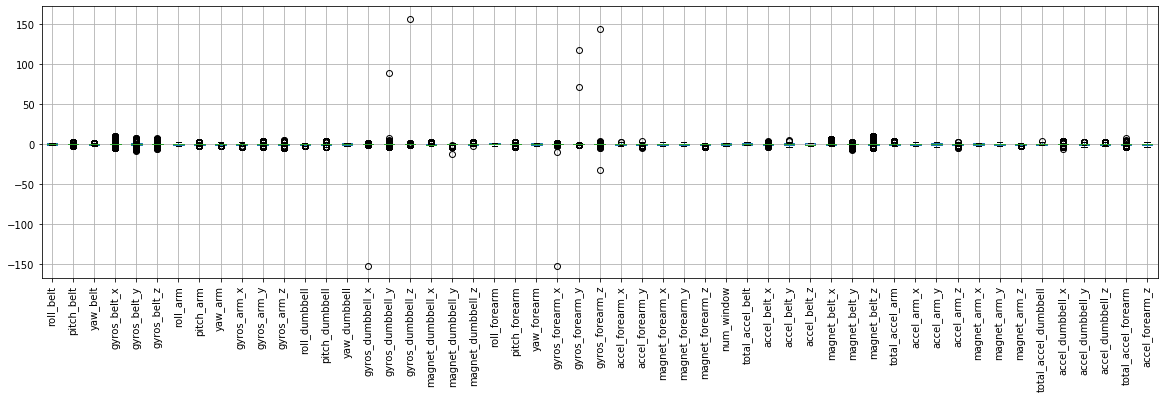

In [126]:
# Boxplot
plt.figure(figsize=(20,5))
X_train.boxplot(rot=90)

In [127]:
# Drop oout the observations in the gyroscope reading with very extreme values 
# (consider only the observations with values between -25 and 25)
index_condition=X_train[(X_train['gyros_dumbbell_x']<=-25) | 
                        (X_train['gyros_dumbbell_y']>=25)  |
                        (X_train['gyros_dumbbell_z']>=25)  |
                        (X_train['gyros_forearm_x']<= -25) |
                        (X_train['gyros_forearm_y']>= 25)  |
                        (X_train['gyros_forearm_z']<= -25) |
                        (X_train['gyros_forearm_z']>= 25)].index
# Drop the observations from the independent and dependent
X_train.drop(index_condition, inplace=True)
y_train.drop(index_condition,inplace=True)

Other anomaly detection approaches

In [128]:
# Select only the numerical features
standar_numeric_data=X_train[type_var['float'].append(type_var['int'])]

In [23]:
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
principalComponents = pca.fit_transform(standar_numeric_data)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2',
                         'principal component 3'])

In [125]:
# Compute the percent of outliers with univariate IQR method
from functions import iqr_rule 
predictions_iqr = standar_numeric_data.apply(iqr_rule,axis=0).all(axis=1)
sum(predictions_iqr)/len(predictions_iqr)

0.2854014017202931

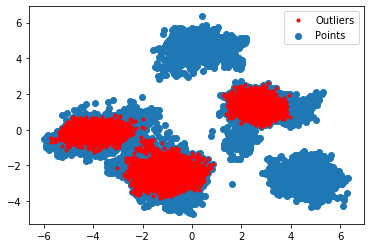

In [126]:
# Results Interquantile Range
#ax = plt.axes(projection='3d')
#ax.scatter(principalComponents[:,0],principalComponents[:,1],
#            principalComponents[:,2],label='Points')3
#ax.scatter3D(principalComponents[predictions_iqr,0],principalComponents[predictions_iqr,1],
#       principalComponents[predictions_iqr,2],'r*')
plt.scatter(principalComponents[:,0],principalComponents[:,1],label='Points')
plt.plot(principalComponents[predictions_iqr,0],principalComponents[predictions_iqr,1],'r.',label='Outliers')
plt.legend()

In [127]:
# Fit the isolation Forest
clf = IsolationForest(random_state=0).fit(standar_numeric_data)
# Make the predictions
predictions_if=clf.predict(standar_numeric_data)
sum(predictions_if==-1)/len(predictions_if)

0.10317776361898694

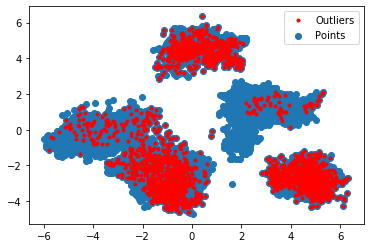

In [128]:
# Results Interquantile Range
plt.scatter(principalComponents[:,0],principalComponents[:,1],label='Points')
plt.plot(principalComponents[predictions_if==-1,0],
         principalComponents[predictions_if==-1,1],'r.',label='Outliers')
plt.legend()

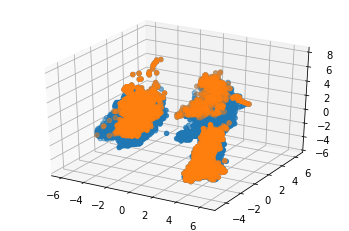

In [129]:
ax = plt.axes(projection='3d')
ax.scatter(principalComponents[:,0],principalComponents[:,1],
            principalComponents[:,2],label='Points')
ax.scatter(principalComponents[predictions_if==-1,0],principalComponents[predictions_if==-1,1],
       principalComponents[predictions_if==-1,2],'r.')

In [130]:
from sklearn.neighbors import LocalOutlierFactor
lof = LocalOutlierFactor(novelty=True)
lof.fit(standar_numeric_data)
# Make the predictions
predictions_lof=lof.predict(standar_numeric_data)

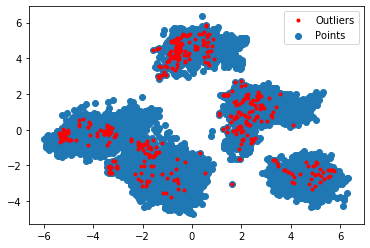

In [131]:
# Results Local Outlier Factor
plt.scatter(principalComponents[:,0],principalComponents[:,1],label='Points')
plt.plot(principalComponents[predictions_lof==-1,0],
         principalComponents[predictions_lof==-1,1],'r.',label='Outliers')
plt.legend()

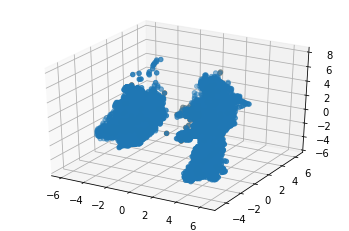

In [132]:
ax = plt.axes(projection='3d')
ax.scatter(principalComponents[:,0],principalComponents[:,1],
            principalComponents[:,2],label='Points')
ax.scatter(principalComponents[predictions_lof==-1,0],principalComponents[predictions_lof==-1,1],
       principalComponents[predictions_lof==-1,2],'r.')

In [133]:
pca.explained_variance_ratio_

array([0.17477819, 0.16191741, 0.09560578])

## Final Data Preprocessing
<a id='Final_Data_Preprocessing'></a>
The first consideration is to drop out some variables like `user_name`, `raw_timestamp_part_1`, `raw_timestamp_part_2`, `cvtd_timestamp`. These features describe experimental conditions but not are directly related to the performance of the exercises.

In [129]:
# Drop the variables "user_name", "raw_timestamp_part_1", "raw_timestamp_part_2", "cvtd_timestamp"
X_train.drop(columns=['user_name', 'raw_timestamp_part_1', 
                                 'raw_timestamp_part_2', 'cvtd_timestamp'],inplace=True)
X_train.head()

,roll_belt,pitch_belt,yaw_belt,gyros_belt_x,gyros_belt_y,gyros_belt_z,roll_arm,pitch_arm,yaw_arm,gyros_arm_x,gyros_arm_y,gyros_arm_z,roll_dumbbell,pitch_dumbbell,yaw_dumbbell,gyros_dumbbell_x,gyros_dumbbell_y,gyros_dumbbell_z,magnet_dumbbell_x,magnet_dumbbell_y,magnet_dumbbell_z,roll_forearm,pitch_forearm,yaw_forearm,gyros_forearm_x,gyros_forearm_y,gyros_forearm_z,accel_forearm_x,accel_forearm_y,magnet_forearm_x,magnet_forearm_y,magnet_forearm_z,num_window,total_accel_belt,accel_belt_x,accel_belt_y,accel_belt_z,magnet_belt_x,magnet_belt_y,magnet_belt_z,total_accel_arm,accel_arm_x,accel_arm_y,accel_arm_z,magnet_arm_x,magnet_arm_y,magnet_arm_z,total_accel_dumbbell,accel_dumbbell_x,accel_dumbbell_y,accel_dumbbell_z,total_accel_forearm,accel_forearm_z,new_window
36557,-1.021721,0.095449,-0.825405,-0.209831,-0.255327,0.431051,1.736301,-0.033211,-1.449336,0.929049,-0.564726,-0.261731,-0.370598,1.343279,1.417868,0.190427,-0.848897,-0.387661,-0.052070,0.027569,2.451428,-1.959027,0.020832,0.904494,0.021338,-0.289700,-0.075488,-0.044818,0.837878,-1.362467,1.583112,-2.554679,1.500141,-1.216846,0.054551,-1.100129,0.961073,-0.446507,-0.593657,-1.361177,3.022254,-0.112801,-0.698711,-3.586379,-0.942877,-1.801264,-2.502058,-0.758983,0.757798,-0.671753,0.845056,0.530408,1.910597,no
13155,-1.415713,-0.151155,-0.824353,-0.738796,-2.162953,-0.709694,1.104827,-0.314106,0.447678,1.938186,-1.543598,-0.370819,0.408974,0.752048,1.210650,-0.419198,0.883116,0.081152,0.182394,0.296593,2.365426,-1.949737,0.244531,-0.050166,-0.215731,-0.999836,-0.665789,0.769019,0.496963,1.602314,-0.468220,-1.833000,-0.573307,-0.182295,-0.751996,-1.274658,1.637464,-1.435389,1.785666,1.891069,-0.614785,0.228319,1.407412,0.418149,1.040343,-0.409772,-0.141791,-0.369066,0.668871,-0.065707,1.091091,-0.361754,1.371799,no
20336,-1.023316,0.132016,-0.814883,0.800011,-0.128152,0.642300,-0.231036,0.134027,0.013120,-1.659387,2.242158,-0.734445,0.864018,-0.712253,-0.729097,-0.158992,2.752318,0.155175,0.229287,1.051697,0.122204,1.217852,0.965340,-1.624534,-0.036811,-1.004402,-1.274730,-0.006064,-0.706266,-0.391545,-1.302996,-0.229570,0.035819,-0.958208,-0.315116,-0.820883,1.130171,-0.183835,1.077534,0.698579,0.533754,0.778514,-0.051375,-1.666605,0.923020,-1.741415,-2.025674,1.775478,-1.287504,2.284264,-1.259911,-1.253916,-1.111039,no
17667,-1.017574,0.292554,-0.873806,0.126783,-0.255327,0.346552,0.756760,0.617881,1.405935,0.762542,-0.352441,0.120078,0.919606,0.595793,0.802698,-0.218468,-0.111505,0.219329,-0.576683,0.348564,-0.393809,0.948468,-0.135757,0.736536,-0.086014,-0.024826,-0.106557,1.062443,0.537071,0.322199,0.643495,0.030885,-0.186048,-1.087527,-0.382328,-0.925600,0.941179,-0.863692,0.114475,0.543710,0.533754,-1.108654,0.960659,0.110685,-1.064713,0.867009,0.724362,-1.051421,0.476198,-0.399651,0.507897,0.332150,-1.205692,no
10556,-1.016936,0.140043,-0.823301,-0.065568,-0.509678,0.431051,0.825548,-0.720024,0.627351,1.605171,-0.777012,0.120078,-1.991131,-0.832407,-0.097306,-0.002869,-0.608816,-0.057024,-0.336357,0.039797,1.813579,1.282876,0.180617,0.865883,-0.171001,-0.079627,0.110923,-0.022673,0.617286,-1.059054,1.523768,-2.505843,-0.795174,-1.087527,-0.113480,-0.890694,0.990914,-0.307445,-0.565331,-1.314717,-0.901920,0.437394,1.106537,0.178177,0.895945,-0.614257,0.229418,-1.051421,0.253883,-0.993328,0.334761,0.133892,1.881473,no


Also, the variable `new_window` have two levels, so, in this case is feasible to use one hot encoding to encode this feature. 

In [130]:
# Encode the "new_window" variable
X_train=pd.get_dummies(X_train,columns=['new_window'])
X_train.head()

,roll_belt,pitch_belt,yaw_belt,gyros_belt_x,gyros_belt_y,gyros_belt_z,roll_arm,pitch_arm,yaw_arm,gyros_arm_x,gyros_arm_y,gyros_arm_z,roll_dumbbell,pitch_dumbbell,yaw_dumbbell,gyros_dumbbell_x,gyros_dumbbell_y,gyros_dumbbell_z,magnet_dumbbell_x,magnet_dumbbell_y,magnet_dumbbell_z,roll_forearm,pitch_forearm,yaw_forearm,gyros_forearm_x,gyros_forearm_y,gyros_forearm_z,accel_forearm_x,accel_forearm_y,magnet_forearm_x,magnet_forearm_y,magnet_forearm_z,num_window,total_accel_belt,accel_belt_x,accel_belt_y,accel_belt_z,magnet_belt_x,magnet_belt_y,magnet_belt_z,total_accel_arm,accel_arm_x,accel_arm_y,accel_arm_z,magnet_arm_x,magnet_arm_y,magnet_arm_z,total_accel_dumbbell,accel_dumbbell_x,accel_dumbbell_y,accel_dumbbell_z,total_accel_forearm,accel_forearm_z,new_window_no,new_window_yes
36557,-1.021721,0.095449,-0.825405,-0.209831,-0.255327,0.431051,1.736301,-0.033211,-1.449336,0.929049,-0.564726,-0.261731,-0.370598,1.343279,1.417868,0.190427,-0.848897,-0.387661,-0.052070,0.027569,2.451428,-1.959027,0.020832,0.904494,0.021338,-0.289700,-0.075488,-0.044818,0.837878,-1.362467,1.583112,-2.554679,1.500141,-1.216846,0.054551,-1.100129,0.961073,-0.446507,-0.593657,-1.361177,3.022254,-0.112801,-0.698711,-3.586379,-0.942877,-1.801264,-2.502058,-0.758983,0.757798,-0.671753,0.845056,0.530408,1.910597,1,0
13155,-1.415713,-0.151155,-0.824353,-0.738796,-2.162953,-0.709694,1.104827,-0.314106,0.447678,1.938186,-1.543598,-0.370819,0.408974,0.752048,1.210650,-0.419198,0.883116,0.081152,0.182394,0.296593,2.365426,-1.949737,0.244531,-0.050166,-0.215731,-0.999836,-0.665789,0.769019,0.496963,1.602314,-0.468220,-1.833000,-0.573307,-0.182295,-0.751996,-1.274658,1.637464,-1.435389,1.785666,1.891069,-0.614785,0.228319,1.407412,0.418149,1.040343,-0.409772,-0.141791,-0.369066,0.668871,-0.065707,1.091091,-0.361754,1.371799,1,0
20336,-1.023316,0.132016,-0.814883,0.800011,-0.128152,0.642300,-0.231036,0.134027,0.013120,-1.659387,2.242158,-0.734445,0.864018,-0.712253,-0.729097,-0.158992,2.752318,0.155175,0.229287,1.051697,0.122204,1.217852,0.965340,-1.624534,-0.036811,-1.004402,-1.274730,-0.006064,-0.706266,-0.391545,-1.302996,-0.229570,0.035819,-0.958208,-0.315116,-0.820883,1.130171,-0.183835,1.077534,0.698579,0.533754,0.778514,-0.051375,-1.666605,0.923020,-1.741415,-2.025674,1.775478,-1.287504,2.284264,-1.259911,-1.253916,-1.111039,1,0
17667,-1.017574,0.292554,-0.873806,0.126783,-0.255327,0.346552,0.756760,0.617881,1.405935,0.762542,-0.352441,0.120078,0.919606,0.595793,0.802698,-0.218468,-0.111505,0.219329,-0.576683,0.348564,-0.393809,0.948468,-0.135757,0.736536,-0.086014,-0.024826,-0.106557,1.062443,0.537071,0.322199,0.643495,0.030885,-0.186048,-1.087527,-0.382328,-0.925600,0.941179,-0.863692,0.114475,0.543710,0.533754,-1.108654,0.960659,0.110685,-1.064713,0.867009,0.724362,-1.051421,0.476198,-0.399651,0.507897,0.332150,-1.205692,1,0
10556,-1.016936,0.140043,-0.823301,-0.065568,-0.509678,0.431051,0.825548,-0.720024,0.627351,1.605171,-0.777012,0.120078,-1.991131,-0.832407,-0.097306,-0.002869,-0.608816,-0.057024,-0.336357,0.039797,1.813579,1.282876,0.180617,0.865883,-0.171001,-0.079627,0.110923,-0.022673,0.617286,-1.059054,1.523768,-2.505843,-0.795174,-1.087527,-0.113480,-0.890694,0.990914,-0.307445,-0.565331,-1.314717,-0.901920,0.437394,1.106537,0.178177,0.895945,-0.614257,0.229418,-1.051421,0.253883,-0.993328,0.334761,0.133892,1.881473,1,0


### Transform Validation Data
Before going ahead with the feature selection analysis, let's transform the validation data using all the previously implemented steps. All these functions are included in the file "functions.py".

In [131]:
# Transform the data types
X_val = types_features(X_val)
# Drop the columns with more than 40% of missing data
X_val.drop(columns=columns_out,inplace=True)
# Impute NaN with the median
X_val[dictionary['float']]=imputer.transform(X_val[dictionary['float']])
# Standarize the data
X_val = standardizer_data(X_val,type_var,scaler)
# Drop the variables "user_name", "raw_timestamp_part_1", "raw_timestamp_part_2", "cvtd_timestamp"
X_val.drop(columns=['user_name', 'raw_timestamp_part_1',
                    'raw_timestamp_part_2', 'cvtd_timestamp'],inplace=True)
# Encode the "new_window" variable
X_val=pd.get_dummies(X_val,columns=['new_window'])
print('The validation dataset has {} features and {} observations, while the train dataset has {} \
features and {} observations'.format(X_val.shape[0],X_val.shape[1],
                                      encoded_train_data.shape[0],encoded_train_data.shape[1]))

The validation dataset has 6279 features and 55 observations, while the train dataset has 25112 features and 55 observations


In [132]:
# Print the head of the validation dataset 
X_val.head()

,roll_belt,pitch_belt,yaw_belt,gyros_belt_x,gyros_belt_y,gyros_belt_z,roll_arm,pitch_arm,yaw_arm,gyros_arm_x,gyros_arm_y,gyros_arm_z,roll_dumbbell,pitch_dumbbell,yaw_dumbbell,gyros_dumbbell_x,gyros_dumbbell_y,gyros_dumbbell_z,magnet_dumbbell_x,magnet_dumbbell_y,magnet_dumbbell_z,roll_forearm,pitch_forearm,yaw_forearm,gyros_forearm_x,gyros_forearm_y,gyros_forearm_z,accel_forearm_x,accel_forearm_y,magnet_forearm_x,magnet_forearm_y,magnet_forearm_z,num_window,total_accel_belt,accel_belt_x,accel_belt_y,accel_belt_z,magnet_belt_x,magnet_belt_y,magnet_belt_z,total_accel_arm,accel_arm_x,accel_arm_y,accel_arm_z,magnet_arm_x,magnet_arm_y,magnet_arm_z,total_accel_dumbbell,accel_dumbbell_x,accel_dumbbell_y,accel_dumbbell_z,total_accel_forearm,accel_forearm_z,new_window_no,new_window_yes
18224,-1.018371,0.074936,-0.809622,-0.113655,-0.509678,0.346552,1.708786,-0.681056,-0.945137,0.671719,-0.222711,-0.498088,0.711140,1.509573,0.763996,-0.359723,0.094279,0.041673,0.583913,0.550333,2.329592,1.282876,0.301344,-0.934360,-0.551206,0.696728,0.657727,0.780091,-1.147450,1.847934,-2.282176,-0.877996,-0.141675,-1.087527,-0.046268,-0.855789,0.990914,-0.245640,-0.706958,-1.144361,2.160850,0.850040,-0.306662,-2.911458,0.336402,-1.896025,-2.514432,0.410768,1.587775,0.837176,1.337126,-1.253916,1.779538,1,0
25166,1.002475,-1.836801,1.805073,0.415310,0.889248,-0.287196,-0.221681,-0.333590,-0.718108,-0.917671,0.308002,0.629155,0.382426,-0.585948,-1.164688,-0.047475,-0.111505,-0.071829,-0.682192,0.122339,0.064869,-0.314853,-0.394609,-0.186270,0.307610,-0.186947,-0.218403,-0.880801,0.832865,-1.053275,0.358643,0.649467,0.463417,0.852257,1.802067,0.540444,-0.889054,1.747576,0.199451,0.357867,-1.284766,-0.134809,-0.862825,0.800604,0.591355,-0.315011,0.557319,0.313289,-0.368601,0.354814,-0.895414,0.629537,0.454387,1,0
20301,-1.030494,0.222987,-0.814883,0.415310,-0.128152,0.684550,-0.231036,0.134027,0.013120,-0.054859,0.272621,-0.552632,0.460841,-1.246683,-0.874025,0.748012,-1.209018,-0.466619,-0.559098,0.290479,0.358709,0.957757,-0.698201,0.520313,-0.564625,0.452404,0.458889,1.710191,0.867959,0.686295,0.651408,1.257197,0.035819,-0.828889,-0.214298,-1.169941,1.160012,-0.122030,1.020884,0.574684,0.916600,-1.048133,1.361825,-0.489244,-1.152705,1.420613,0.319126,1.775478,-2.087840,1.418485,-1.515058,0.926925,-0.426620,1,0
16879,-1.014862,0.312175,-0.867493,0.030608,-0.509678,0.473301,0.793906,-0.960327,0.837666,-2.471742,1.558127,-1.898051,-1.841361,-0.079574,0.596113,-0.121820,-0.265843,-0.007675,-0.723223,0.082596,-0.300640,1.087804,-0.452487,0.827272,-0.001027,-0.029392,-0.081702,1.007080,0.527044,0.382882,0.639539,0.071582,-0.258659,-1.087527,-0.382328,-0.925600,0.921285,-0.770984,0.142800,0.466275,-0.901920,-0.266856,0.741841,0.673119,0.740266,-0.649169,0.452143,-1.051421,0.372451,-0.968591,0.480559,0.431279,-1.416843,0,1
26756,1.433155,-1.622750,1.542025,-0.642621,1.779473,1.191548,-1.183062,-1.794894,0.462999,0.363933,-0.470377,0.956419,0.641618,-0.375234,-1.009689,-0.017737,0.917413,0.120631,-0.456520,0.476962,0.057702,-0.314853,-0.394609,-0.186270,0.325502,0.434137,0.129564,-1.805364,-0.004382,-0.969475,-0.677903,0.155687,0.612673,1.628170,2.440583,0.505538,-1.436135,1.685771,-2.009920,-1.670915,0.246619,1.180157,-1.364283,-0.916694,1.245660,-1.182823,-1.527636,0.508248,-0.250032,0.812440,-0.895414,0.827796,0.483511,1,0


## Feature Selection/Importance
<a id='Feature_Selection_Importance'></a>

Now is the moment to compute the feature importance in our dataset! There are three main classes of methods to feature selection:
1. Univariate: Uses hypothesis statistical tests to compute the relationship between each feature and the target.
2. Model-Base: Use supervised machine learning algorithms to evaluate the importance of each feature. Some classic examples for this alternative are the Lasso Regression and tree-based models.
3. Iterative: Use a series of models considering different amounts of features (increasing by one or reducing by one).

In my experience, a really nice and powerful alternative is to use Random Forest with two objectives. The first one is for feature selection and the second one is for our classification task. Random Forest is an ensemble method that doesn't need feature normalization and works well using a mixture of features types like continuous and binary variables.

In [156]:
from sklearn.ensemble import RandomForestClassifier
# Set and fit the model
rfc_fs=RandomForestClassifier(random_state=1)
rfc_fs.fit(encoded_train_data,y_train);
# Extract the names of the features
features = encoded_train_data.columns
#  Extract the importance of the features from the RF
importance=rfc_fs.feature_importances_
print('A total of {} features have not importance in order to predict \
the dependent variable.'.format(sum(importance == 0)))

A total of 0 features have not importance in order to predict the dependent variable.


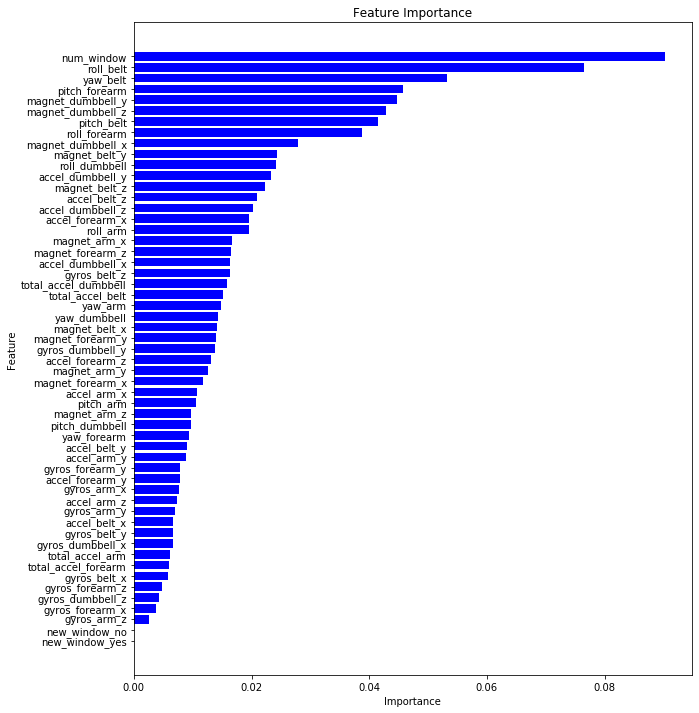

In [181]:
# Index of the features with importance different to zero
index=importance != 0
# Extract the most important features (mi)
features_mi=features[index]
importance_mi=importance[index]

## Plot the features importance for those features with importance different to zero
# Sort the values in descending order
indices = np.argsort(importance_mi)
# plot the results
plt.figure(figsize=(10,12))
plt.title('Feature Importance')
plt.barh(range(len(indices)), importance_mi[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features_mi[i] for i in indices])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

In [189]:
from sklearn.neighbors import KNeighborsClassifier
clf=KNeighborsClassifier(n_neighbors=5)
clf.fit(X_train,y_train)
clf.score(X_train,y_train)

0.9953010512902198

In [165]:
from sklearn.metrics import accuracy_score
# Create a serie with the name of the feature and the importance 
feature_importance=pd.Series(importance,index=features)
# Create an array with 20 differents thresholds
thresholds=np.linspace(0,0.08,20)
# Create to vectors to store the AUC in the training and validation
auc_train=np.zeros(len(thresholds))
auc_val=np.zeros(len(thresholds))
# For each threshold fit a model and compute the AUC
for i, threshold in enumerate(thresholds):
    actual_features=feature_importance[feature_importance > threshold].index
    # Include only the variables in actual_features
    actual_train=X_train[actual_features]
    actual_val=X_val[actual_features]
    # Fit the model
    rfc_fs.fit(actual_train,y_train)
    # Predict the probability of each class for the training and validation dataset
    prob_train=rfc_fs.predict(actual_train)
    prob_val=rfc_fs.predict(actual_val)
    # Compute the AUC for the training and testing and save the information in array auc_train & auc_val
    auc_train[i]=accuracy_score(y_train, prob_train)
    auc_val[i]=accuracy_score(y_val, prob_val)

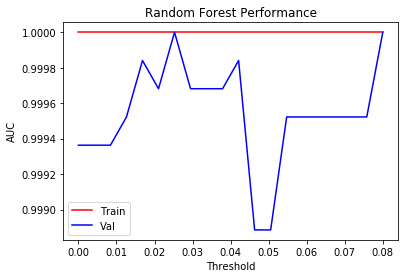

In [166]:
# Plot the AUC in relation with the thresholds
plt.plot(thresholds,auc_train,'-r',label='Train')
plt.plot(thresholds,auc_val,'-b',label='Val')
plt.title('Random Forest Performance')
#plt.axvline(x=0.0038)
plt.ylabel('AUC')
plt.xlabel('Threshold')
plt.legend()
plt.show()

## Classification Model
<a id='Classification_Model'></a>

## Conclusions and Remarks
<a id='Conclusions_and_Remarks'></a>